In [1]:
import numpy as np
import scipy.special as ss
import matplotlib.pyplot as pl
%matplotlib inline

class neuralNetworks:

    def __init__(self, inputNodes, hiddenNodes, outputNodes, learningRate):
        self.inodes = inputNodes
        self.hnodes = hiddenNodes
        self.onodes = outputNodes
        
        self.lr = learningRate

        self.wih = np.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = np.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # create the sigmoid activation/squashing function using the lambda notation.
        self.activation_function = lambda x: ss.expit(x)
        self.inverse_activation_function = lambda x: ss.logit(x)

        self.scale_image = lambda array:  (np.asfarray(array[1:]) / 255.0 * 0.99) + 0.01

    def train(self, input_list, target_list):
        inputs = np.array(input_list, ndmin=2).T
        targets = np.array(target_list, ndmin=2).T
        
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        # Pythons magic matrix maths!
        output_errors = targets - final_outputs

        # Propogate the error back accoss contribuiting nodes (by their relative wieghts)
        hidden_errors = np.dot(self.who.T, output_errors)

        self.who += self.lr * np.dot((output_errors * final_outputs * (1.0 - final_outputs)), np.transpose(hidden_outputs))
        self.wih += self.lr * np.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), np.transpose(inputs))
         

    def query(self, inputs_list):
        inputs = np.array(inputs_list, ndmin=2).T
        
        # the matrix dot product i.e. the result of applying the input values 
        # accross the wieghted connections into the hidden nodes.
        hidden_inputs = np.dot(self.wih, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        

        final_inputs = np.dot(self.who, hidden_outputs)
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = np.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = np.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= np.min(hidden_outputs)
        hidden_outputs /= np.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = np.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= np.min(inputs)
        inputs /= np.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs


Lets create a neural network and train it using a MNist training data set.

The larger datasets (mnist_train.csv and mnist_test.csv) can be found here [here](https://github.com/pjreddie/mnist-csv-png).

In [3]:
i_nodes, h_nodes, o_nodes, l_rate = 784, 100, 10, 0.05
nn = neuralNetworks(i_nodes, h_nodes, o_nodes, l_rate)
epoc = 6

with open("mnist_data/mnist_train.csv") as train_file:
    train_list = train_file.readlines()

for _ in range(epoc):
    for records in train_list:
        all_values = records.split(",")
        # scale the inputs from 0-255 to (+ 1.0) to (- 0.99)
        scaled_inputs = nn.scale_image(all_values)
        targets = np.zeros(o_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        nn.train(scaled_inputs, targets)


Test the network against the training data.

In [4]:
with open("mnist_data/mnist_test.csv") as mnist_file:
    test_data = mnist_file.readlines()
    score_card = []

    for test in test_data:
        test_input = test.split(",")
        image_array = nn.scale_image(test_input)


        predictions = nn.query(image_array)

        predicted_number = str(np.argmax(predictions))
        actual_number = (test_input[0])
        # print(f"Predicted : {predicted_number}, actual {actual_number}")
        score_card.append(predicted_number == actual_number)
        percent = (sum(score_card) / len(score_card) )
    
    print(percent)

    #pl.imshow(image_array.reshape(28,28), cmap='Greys', interpolation='none')

0.9679


Run the network backwards to see what the network sees a number as.

[0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01 0.01]


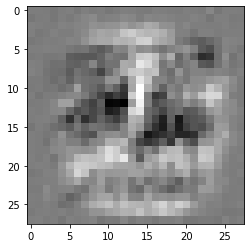

In [5]:
import matplotlib.pyplot as pl
%matplotlib inline

# label to test
label = 4
# create the output signals for this label
targets = np.zeros(o_nodes) + 0.01
# all_values[0] is the target label for this record
targets[label] = 0.99
print(targets)

# get image data
image_data = nn.backquery(targets)

# plot image data
pl.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')


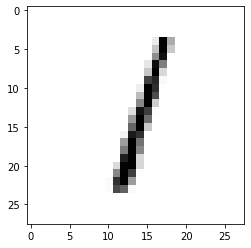

In [7]:
# print out a number from an image array.
import matplotlib.pyplot as pl
%matplotlib inline

with open("mnist_data/mnist_test.csv") as mnist_file:
    test_data = mnist_file.readlines()

    image_data = test_data[2].split(",")
    image_array = nn.scale_image(image_data)

    pl.imshow(image_array.reshape(28,28), cmap='Greys', interpolation='None')